In [ ]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import itertools as it
import collections as co
import time

from sklearn import datasets, metrics, neighbors, naive_bayes, linear_model, dummy, pipeline, feature_selection as ftr_sel, model_selection as skms, preprocessing as skpre
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn import tree, svm, ensemble as ens
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, ParameterGrid
from sklearn.feature_selection import SelectKBest, f_regression

from scipy.stats import zscore
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
#1. Data Selection
tips = sns.load_dataset('tips')
print(tips)

     total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
..          ...   ...     ...    ...   ...     ...   ...
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

[244 rows x 7 columns]


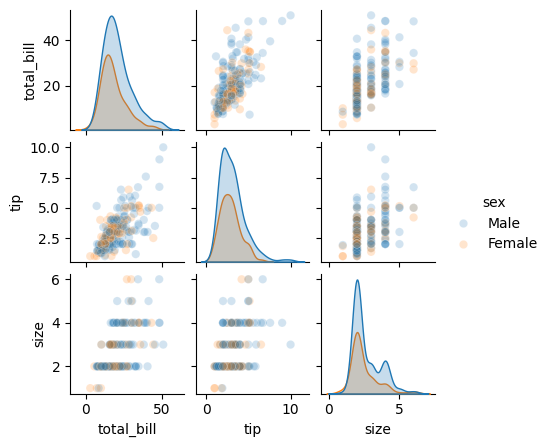

In [ ]:
sns.pairplot(tips[['total_bill', 'tip', 'sex', 'smoker', 'day', 'time', 'size']],
             height=1.5, hue='sex', plot_kws={'alpha':.2});

In [ ]:
#2. Data Preprocessing

#Missing Values (None)
missing_values = tips.isnull().sum()
print(missing_values)

#Removing Duplicates
tips = tips.drop_duplicates()

#Detecting Outliers w/ z-score
z_scores = tips.select_dtypes(include=['float64', 'int64']).apply(zscore)

outliers = tips[(z_scores > 3).any(axis=1)]
print("\nOutliers using Z-Score:\n", outliers)

tips = tips[(z_scores <= 3).all(axis=1)]
print("\nData without outliers:\n", tips)

#Encoding
tips['sex'] = tips['sex'].map({'Female': 0, 'Male': 1})
tips['smoker'] = tips['smoker'].map({'No': 0, 'Yes': 1})
tips['day'] = tips['day'].map({'Thur': 0, 'Fri': 1, 'Sat': 2, 'Sun': 3})
tips['time'] = tips['time'].map({'Lunch': 0, 'Dinner': 1})

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

Outliers using Z-Score:
      total_bill    tip     sex smoker   day    time  size
23        39.42   7.58    Male     No   Sat  Dinner     4
59        48.27   6.73    Male     No   Sat  Dinner     4
125       29.80   4.20  Female     No  Thur   Lunch     6
141       34.30   6.70    Male     No  Thur   Lunch     6
143       27.05   5.00  Female     No  Thur   Lunch     6
156       48.17   5.00    Male     No   Sun  Dinner     6
170       50.81  10.00    Male    Yes   Sat  Dinner     3
212       48.33   9.00    Male     No   Sat  Dinner     4

Data without outliers:
      total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  

In [ ]:
#Creating training and testing splits in the data
(tips_train_ftrs, tips_test_ftrs,
tips_train_tgt, tips_test_tgt) = skms.train_test_split(tips.drop('tip', axis=1),
                                                        tips['tip'],
                                                        test_size=0.3,
                                                        random_state=42)

#Shape of train/test features
print("Train features shape:", tips_train_ftrs.shape)
print("Test features shape:", tips_test_ftrs.shape)

Train features shape: (164, 6)
Test features shape: (71, 6)


In [ ]:
#3. Feature Engineering

#Feature Selection
select_k_best = SelectKBest(score_func=f_regression, k=2)
tips_train_k_best = select_k_best.fit_transform(tips_train_ftrs, tips_train_tgt)

#Selected feature names
selected_features = tips_train_ftrs.columns[select_k_best.get_support()]
print("Selected features:", selected_features)

#Added features
tips['tip_percentage'] = tips['tip'] / tips['total_bill']
tips['price_per_person'] = tips['total_bill'] / tips['size']

print("\nAdded features:\n", tips[['tip_percentage', 'price_per_person']].head())

#Finalized data set after added features
print("\nTips with added features:\n", tips.head())

Selected features: Index(['total_bill', 'size'], dtype='object')

Added features:
    tip_percentage  price_per_person
0        0.059447          8.495000
1        0.160542          3.446667
2        0.166587          7.003333
3        0.139780         11.840000
4        0.146808          6.147500

Tips with added features:
    total_bill   tip sex smoker day time  size  tip_percentage  \
0       16.99  1.01   0      0   3    1     2        0.059447   
1       10.34  1.66   1      0   3    1     3        0.160542   
2       21.01  3.50   1      0   3    1     3        0.166587   
3       23.68  3.31   1      0   3    1     2        0.139780   
4       24.59  3.61   0      0   3    1     4        0.146808   

   price_per_person  
0          8.495000  
1          3.446667  
2          7.003333  
3         11.840000  
4          6.147500  


In [ ]:
#4. Modeling

#Linear Regression Modeling
lr = linear_model.LinearRegression()
fit = lr.fit(tips_train_ftrs, tips_train_tgt)
preds = lr.predict(tips_train_ftrs)

mse = mean_squared_error(tips_train_tgt, preds)

#Mean Squared Error for evaluation of model
print("MSE: ", mse)
print("RMSE: ", np.sqrt(mse))

MSE:  0.7973255997139169
RMSE:  0.8929309042215511


In [ ]:
#Hyperparameter Tuning

#GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

#Perform search on training features and target
grid_search.fit(tips_train_ftrs, tips_train_tgt)

#Best parameters and model
best_lr = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

#Evaluate best parameters model
preds = best_lr.predict(tips_train_ftrs)
mse = mean_squared_error(tips_train_tgt, preds)
print("MSE:", mse)
print("RMSE:", np.sqrt(mse))


Best Parameters: {'copy_X': True, 'fit_intercept': True}
MSE: 0.7973255997139169
RMSE: 0.8929309042215511


In [ ]:
#5. Model Evaluation

#Creation of Linear Regression and KNN models
lrknn = [linear_model.LinearRegression(),
              neighbors.KNeighborsRegressor(n_neighbors=3),
              neighbors.KNeighborsRegressor(n_neighbors=10)]

#Creation of Lasso and Ridge models
penalized_lr = [linear_model.Lasso(),
                linear_model.Ridge()]

#Creation of SVR models
svrs = [svm.SVR(), svm.NuSVR()]

#Decision Tree Regressor models
dtrees = [tree.DecisionTreeRegressor(max_depth=md) for md in [1, 3, 5, 10]]

#Comibining all models
reg_models = lrknn + penalized_lr + svrs + dtrees

#RMS_Error function
def rms_error(actual, predicted):
  ' root-mean-squared-error function ' #lesser values are better (a<b means a is better)
  mse = metrics.mean_squared_error(actual, predicted)
  return np.sqrt(mse)
rms_scorer = metrics.make_scorer(rms_error)

scaler = StandardScaler()

def rms_error(actual, predicted):
  return np.sqrt(mean_squared_error(actual, predicted))

errors = {}
for model in reg_models:
    pipe = pipeline.make_pipeline(scaler, model)
    preds = skms.cross_val_predict(pipe,
                                   tips_train_ftrs, tips_train_tgt,
                                   cv=10)
    key = (model.__class__.__name__ +
           str(model.get_params().get('max_depth', "")) +
           str(model.get_params().get('n_neighbors', "")))
    errors[key] = rms_error(tips_train_tgt, preds)

#Displaying RMSE
df = pd.DataFrame.from_dict(errors, orient='index').sort_values(0)
df.columns=['RMSE']
display(df)

,RMSE
Ridge,0.941925
LinearRegression,0.942559
SVR,0.962661
NuSVR,0.977174
DecisionTreeRegressor3,1.005350
KNeighborsRegressor3,1.014996
DecisionTreeRegressor1,1.023699
KNeighborsRegressor10,1.024966
DecisionTreeRegressor5,1.112563
Lasso,1.186001


## 6. Model Interpretation
After evaluating ten different regresssion models, I found that the best performing model, according to the RMSE is the Ridge Linear model (0.941925). This is followed by the Linear Regression model, SVR, and NuSVR, the best performing models which I graphed below. The worst performing model, which had the highest RMSE, was the Decision Tree Regressor 10. Additionally, the below visualization shows the comparison of the four best performing models mentioned in terms of RMSE across increasing CV-Fold values.

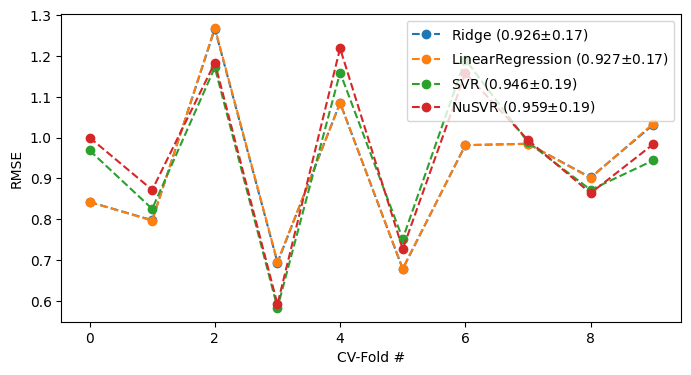

In [ ]:
def rms_error(actual, predicted):
  return np.sqrt(mean_squared_error(actual, predicted))

rms_scorer = make_scorer(rms_error)

#Top performing models for further evaluation
better_models = [linear_model.Ridge(),
                 linear_model.LinearRegression(),
                 svm.SVR(),
                 svm.NuSVR()]

#Line plot of RMSE and CV-Fold
fig, ax = plt.subplots(1, 1, figsize=(8,4))
for model in better_models:
    pipe = pipeline.make_pipeline(scaler, model)
    cv_results = skms.cross_val_score(pipe,
                                      tips_train_ftrs, tips_train_tgt,
                                      scoring = rms_scorer,
                                      cv=10)

    my_lbl = "{:s} ({:5.3f}$\pm${:.2f})".format(model.__class__.__name__,
                                                cv_results.mean(),
                                                cv_results.std())
    ax.plot(cv_results, 'o--', label=my_lbl)
    ax.set_xlabel('CV-Fold #')
    ax.set_ylabel("RMSE")
    ax.legend()